# Machine Learning Engineer Nanodegree
## Capstone Project
Simon Jackson
March 21st, 2017

---

In [1]:
import os
import numpy as np
import pandas as pd

from scripts import utility

# Pretty display for notebooks
%matplotlib inline

## Data Importing and preprocessing

Data was downloaded as .zip format...

Extract all data from zip files into the same directory

In [2]:
# Utility variables
data_directory = "data"

In [3]:
from scripts import extract_zips

# Extract all files from zip folders in data directory,
# into data directory
if False:
    extract_zips.extract_all(data_directory)
else:
    print "Extraction turned off. Check that files have been extracted."
    
print "\nFiles in the data directory:\n"
for f in os.listdir(data_directory):
    print "- " + f

Extraction turned off. Check that files have been extracted.

Files in the data directory:

- genome_scores.csv
- genome_tags.csv
- imdb-5000-movie-dataset.zip
- link.csv
- movie.csv
- movielens-20m-dataset.zip
- movie_metadata.csv
- rating.csv
- tag.csv


### IMDB data

In [4]:
from scripts import data_imdb

imdb = data_imdb.prep(data_directory)
print 'After prep, IMDB data set has {} rows and {} columns'.format(*imdb.shape)

data\movie_metadata.csv read with 5043 rows and 28 columns.
After prep, IMDB data set has 5043 rows and 66 columns


In [5]:
# Column types
imdb.dtypes

color                           bool
num_critic_for_reviews       float64
duration                     float64
director_facebook_likes      float64
actor_3_facebook_likes       float64
actor_1_facebook_likes       float64
gross                        float64
movie_title                   object
num_voted_users                int64
cast_total_facebook_likes      int64
facenumber_in_poster         float64
movie_imdb_link               object
num_user_for_reviews         float64
budget                       float64
title_year                   float64
actor_2_facebook_likes       float64
imdb_score                   float64
aspect_ratio                 float64
movie_facebook_likes           int64
english                         bool
usa                             bool
uk                              bool
approved                       int32
g                              int32
gp                             int32
m                              int32
nc-17                          int32
n

In [6]:
# Examine few rows
imdb.head(n = 5)

,color,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_1_facebook_likes,gross,movie_title,num_voted_users,cast_total_facebook_likes,...,mystery,news,reality-tv,romance,sci-fi,short,sport,thriller,war,western
0,True,723.0,178.0,0.0,855.0,1000.0,760505847.0,Avatar,886204,4834,...,0,0,0,0,1,0,0,0,0,0
1,True,302.0,169.0,563.0,1000.0,40000.0,309404152.0,Pirates of the Caribbean: At World's End,471220,48350,...,0,0,0,0,0,0,0,0,0,0
2,True,602.0,148.0,0.0,161.0,11000.0,200074175.0,Spectre,275868,11700,...,0,0,0,0,0,0,0,1,0,0
3,True,813.0,164.0,22000.0,23000.0,27000.0,448130642.0,The Dark Knight Rises,1144337,106759,...,0,0,0,0,0,0,0,1,0,0
4,False,NaN,NaN,131.0,NaN,131.0,NaN,Star Wars: Episode VII - The Force Awakens ...,8,143,...,0,0,0,0,0,0,0,0,0,0


This information will be used for content-based filtering of movies.

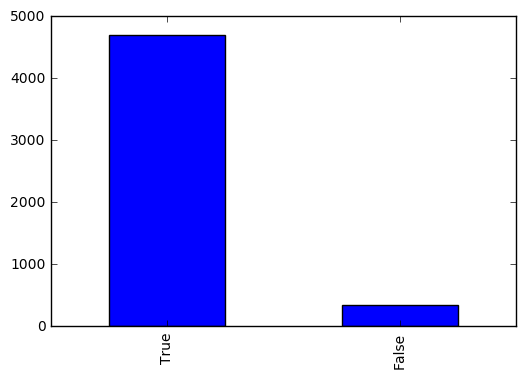

In [7]:
utility.count_plot(imdb.english)

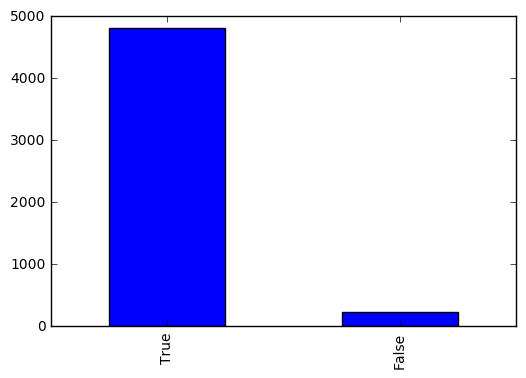

In [8]:
utility.count_plot(imdb['color'])

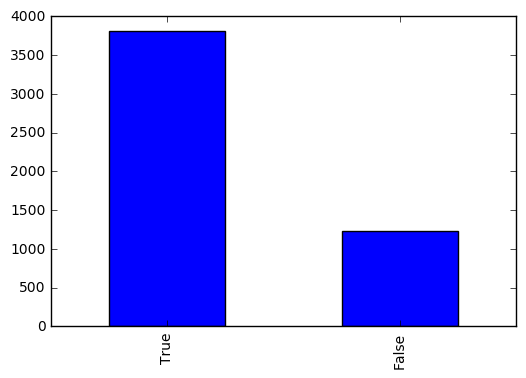

In [9]:
# Visualizing counts for two major countries (USA and UK)
utility.count_plot(imdb.usa)

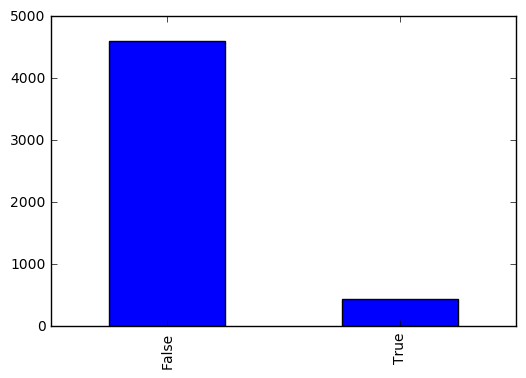

In [10]:
utility.count_plot(imdb.uk)

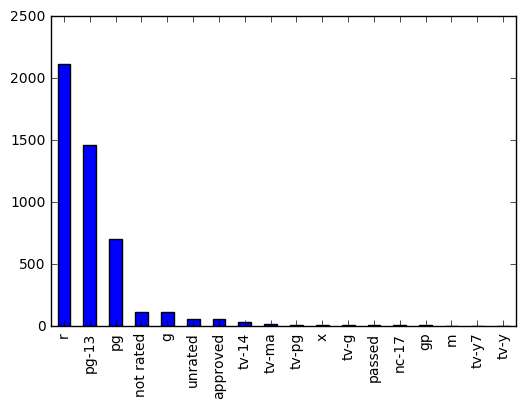

In [11]:
rating_dummies = pd.melt(imdb.ix[:, 'approved':'x'])
utility.count_plot(rating_dummies.variable[rating_dummies.value == 1])

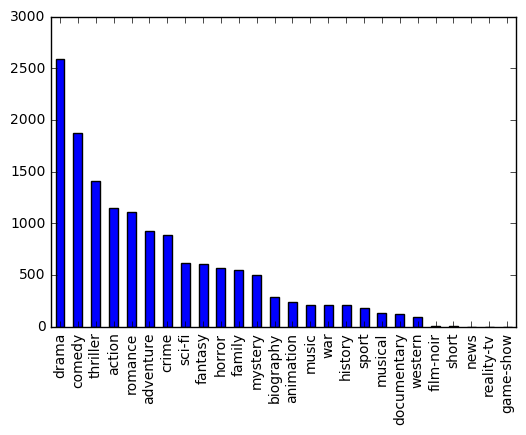

In [12]:
# Visualise counts of genres
genre_dummies = pd.melt(imdb.ix[:, 'action':'western'])
utility.count_plot(genre_dummies.variable[genre_dummies.value == 1])

#### Categorical variables

- `language`: convert to 1 = English, 0 = other
- `genres`: will need to be split into multiple variables indicating whether certain genres were tagged.
- `country`: 1 = USA, 0 = Other (possibly a separate one for UK?)
- `content_rating`: will need a number of categories (R, PG, PG-13, G, etc)

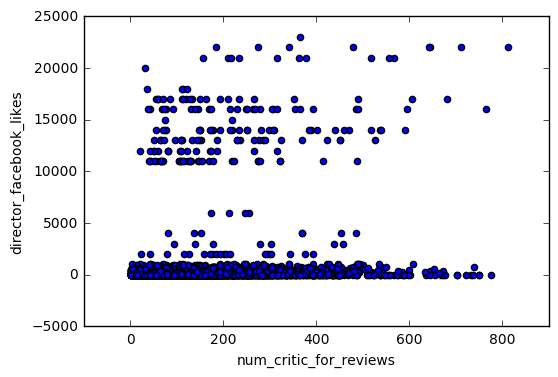

In [13]:
imdb.plot.scatter('num_critic_for_reviews', 'director_facebook_likes')

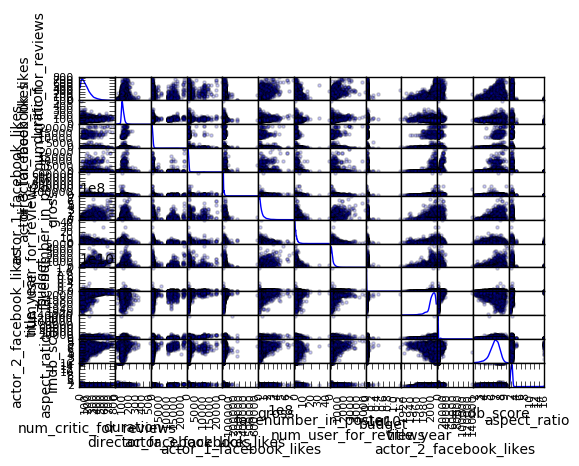

In [16]:
utility.float_scatter_matrix(imdb)

In [15]:
imdb.head(3)

,color,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_1_facebook_likes,gross,movie_title,num_voted_users,cast_total_facebook_likes,...,mystery,news,reality-tv,romance,sci-fi,short,sport,thriller,war,western
0,True,723.0,178.0,0.0,855.0,1000.0,760505847.0,Avatar,886204,4834,...,0,0,0,0,1,0,0,0,0,0
1,True,302.0,169.0,563.0,1000.0,40000.0,309404152.0,Pirates of the Caribbean: At World's End,471220,48350,...,0,0,0,0,0,0,0,0,0,0
2,True,602.0,148.0,0.0,161.0,11000.0,200074175.0,Spectre,275868,11700,...,0,0,0,0,0,0,0,1,0,0
